# Qura question pairs
## cmpt413 Group 1234

This is the development file for project of cmpt413, we choose qura question pair as our topic. The goal of this data set and project is to identify dupilicate question pairs. 

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import re
import math
import os
from nltk.corpus import stopwords
import matplotlib.pyplot as plt 
import nltk
from collections import Counter
from nltk.stem import SnowballStemmer

import seaborn as sns
import xgboost as xgb
import pickle
from sklearn.model_selection import train_test_split

set stop words for data processing and set color for plotings

In [2]:
stop_words=stopwords.words('english')
pal = sns.color_palette()

Load train and test data, fill nan with empty string

In [3]:
import wget
train_link = "http://vault.sfu.ca/index.php/s/tn4aFHCF6OSIyXh/download"
test_link = "http://vault.sfu.ca/index.php/s/Y8lrvslywdz3pzJ/download"
train_download = 'train.csv'
test_download = 'test.csv'
wget.download(train_link, out=train_download)
wget.download(test_link, out=test_download)

In [4]:
train = pd.read_csv('train.csv',low_memory=False)
test = pd.read_csv('test.csv',low_memory=False)
test=test.drop_duplicates()
test=test.drop(test.index[len(test)-1])
test = test.set_index('test_id')

In [11]:
train = train.fillna("")
test = test.fillna("")

In [12]:
print('train shape:',train.shape)
print('test shape:',test.shape)

train shape: (404290, 6)
test shape: (2345796, 2)


In [13]:
train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [14]:
test.head(5)

,question1,question2
test_id,,
0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,What but is the best way to send money from Ch...,What you send money to China?
3,Which food not emulsifiers?,What foods fibre?
4,"How ""aberystwyth"" start reading?",How their can I start reading?


#   

#   

# Data Analysis

We first look at some statisics of the data

In [15]:
def get_len(row):
    return len(row.split())

train['q1_len'] = train['question1'].apply(get_len)
train['q2_len'] = train['question2'].apply(get_len)
test['q1_len'] = test['question1'].apply(get_len)
test['q2_len'] = test['question2'].apply(get_len)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


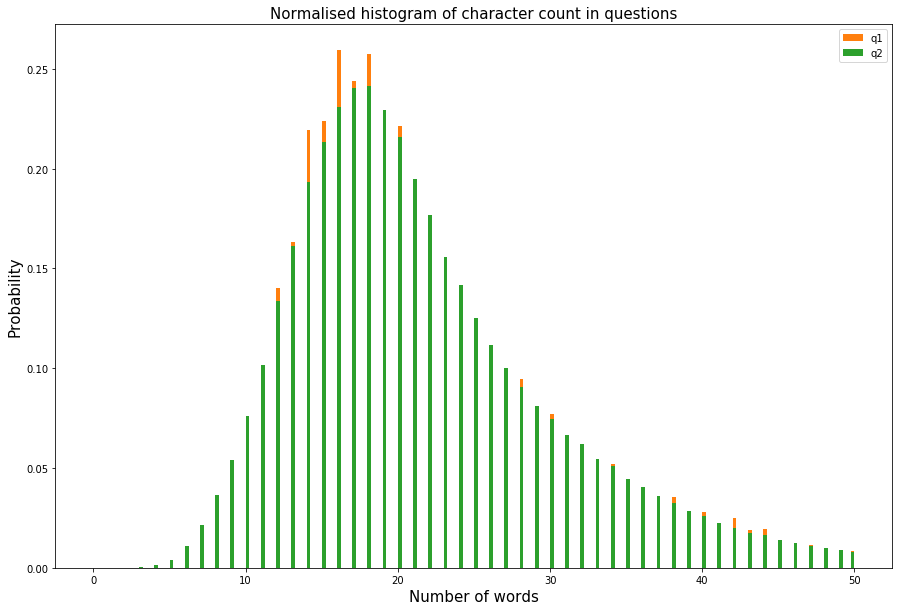

In [16]:
plt.figure(figsize=(15, 10))
plt.hist(train['q1_len']+train['q2_len'], bins=200, range=[0, 50], color = pal[1], normed=True, label='q1')
plt.hist(test['q1_len']+test['q2_len'], bins=200, range=[0, 50], color = pal[2], normed=True, label='q2')

plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.savefig('wordcount.jpg')

From this histogram, we can see , most sentences are about 15 to 40 words. both test and train have similar mean and variance which is good for our model to give the best performance.

Second we have a look at the distribution of result

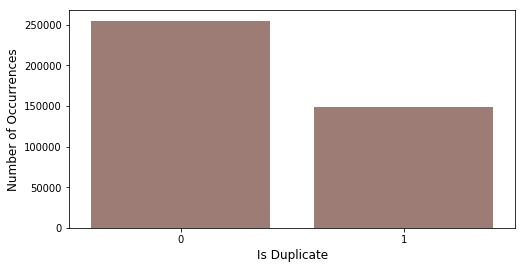

In [17]:
is_dup = train['is_duplicate'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color=pal[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Duplicate', fontsize=12)
plt.savefig("dupcount.jpg")

In [18]:
sum(train['is_duplicate'])/len(train['is_duplicate'])

0.369197853026293

This shows the true results for training set, we have 36.9% of questions marked as duplicate. 

Now we start processing data， we first put combine question pairs in train to a single list

# 1.0 Baseline    (Jaccard Similarity and Cosine Similarity)

####  1.1 Jaccard Similarity   
#### $${\displaystyle J(A,B)={{|A\cap B|} \over {|A\cup B|}}={{|A\cap B|} \over {|A|+|B|-|A\cap B|}}.}$$


In [19]:
def jaccard_similarity(row):
    str1 = row['question1']
    str2 = row['question2']
    if(pd.isnull(str1)==True or pd.isnull(str2)==True):
        return 0
    a = set(str1.split())
    b = set(str2.split())
    c = a.intersection(b)
    if((len(a)+len(b)-len(c))==0):
        return 0
    result = float(len(c) / (len(a) + len(b) - len(c)))
    
    return result

In [21]:
js_df = train.copy()
js_df['js_prediction']= js_df.apply(jaccard_similarity,axis=1)

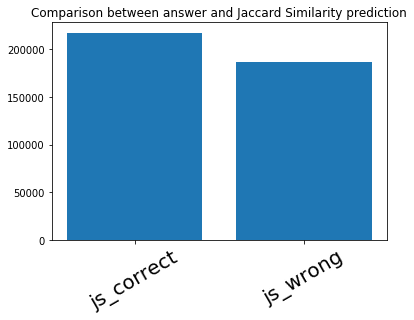

In [22]:
js_correct=0
for index,row in js_df.iterrows():
    score = row['js_prediction']
    real = row['is_duplicate']
    if(abs(score-real)<0.37):
        js_correct+=1
js_wrong=len(js_df)-js_correct
label=['js_correct','js_wrong']
num=[js_correct,js_wrong]
index = np.arange(len(label))
plt.bar(index, num)
plt.xticks(index, label, fontsize=20, rotation=30)
plt.title('Comparison between answer and Jaccard Similarity prediction')
plt.show()

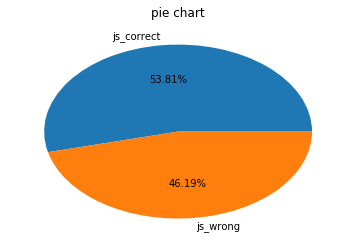

In [23]:
plt.pie(num,labels=label,autopct='%1.2f%%')
plt.title('pie chart')
plt.show()

Run the algorithm for the test file

In [ ]:
js_test = test.copy()
js_test['is_duplicate']= js_test.apply(jaccard_similarity,axis=1)
js_test=js_test.drop(['question1','question2'],axis=1)
js_test.to_csv('js_out.csv')

The score from Kaggle of this model is 0.51397

#   

#### 1.2 Cosine Similarity   
#### $${\displaystyle {\text{similarity}}=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}},}$$


In [24]:
cs_df = train.copy()

In [25]:
# Code cite from :https://stackoverflow.com/questions/15173225/calculate-cosine-similarity-given-2-sentence-strings
WORD = re.compile(r'\w+')
def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)
def get_cosine(row):
    if(pd.isnull(row['question1'])==True or pd.isnull(row['question2'])==True):
        return 0
    vec1=text_to_vector(row['question1'])
    vec2=text_to_vector(row['question2'])
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])
    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
    if not denominator:
        return 0
    result = float(numerator) / denominator

    return result

In [26]:
cs_df['cs_prediction']= cs_df.apply(get_cosine,axis=1)

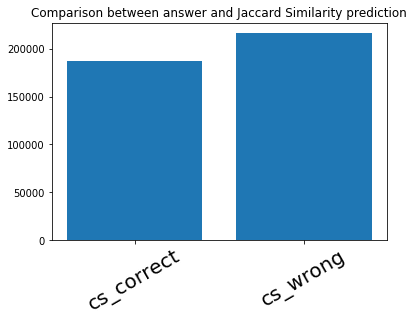

In [27]:
cs_correct=0
for index,row in cs_df.iterrows():
    score = row['cs_prediction']
    real = row['is_duplicate']
    if(abs(score-real)<0.37):
        cs_correct+=1
cs_wrong=len(cs_df)-cs_correct
label=['cs_correct','cs_wrong']
num=[cs_correct,cs_wrong]
index = np.arange(len(label))
plt.bar(index, num)
plt.xticks(index, label, fontsize=20, rotation=30)
plt.title('Comparison between answer and Jaccard Similarity prediction')
plt.show()

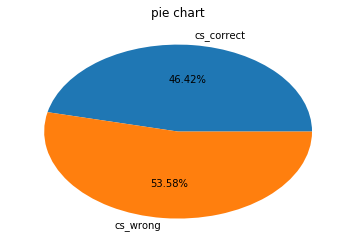

In [28]:
plt.pie(num,labels=label,autopct='%1.2f%%')
plt.title('pie chart')
plt.show()

Run the Cosine Similarity for the test file

In [ ]:
cs_test = test.copy()
cs_test['is_duplicate']= cs_test.apply(get_cosine,axis=1)
cs_test=cs_test.drop(['question1','question2'],axis=1)
cs_test.to_csv('cs_out.csv')

The score of this model is 0.70972

#  

#  

# 2.0 Improvements

## 2.1 Data cleaning

In [29]:
#save cleaned sentences to column[question1_cleaned] and column[question2_cleaned]
train=train.fillna('this is NaN')
test=test.fillna('this is NaN')
stop_words=stopwords.words('english')
stemmer=SnowballStemmer('english')
def cleaning(text1):
    text1 = text1.lower()
    text=[]
    for word in text1.split():
        if word not in stop_words:
            text.append(stemmer.stem(word))
    text = "".join(str(x) for x in text1)
    text = re.sub(r"usa", "America", text)
    text = re.sub(r"uk", "United Kingdom", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"kms", " kilometers", text)
    text = re.sub(r"iphone", "phone", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"android", "operating system", text)
    text= re.sub(r"[^A-Za-z0-9]", " ", text)
    return text

train['question1_cleaned'] = train['question1'].apply(cleaning)
train['question2_cleaned'] = train['question2'].apply(cleaning)
train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,question1_cleaned,question2_cleaned
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14,12,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...


In [30]:
#change short form to normal form
# e.g. I'll -> I will

def replace(text, replacements=()):
    for f,t in replacements:
        text = text.replace(f, t)
    return text

replacements = (("'s", ''), ('"', ''), ("/", ' '), ("'m", ' am'), ("'ve", ' have'), ("'ll", ' will'), ("'re", ' are'))
train['question1_cleaned'] = train['question1_cleaned'].apply(replace, replacements=replacements)
train['question2_cleaned'] = train['question2_cleaned'].apply(replace, replacements=replacements)

train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,question1_cleaned,question2_cleaned
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14,12,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...


## 2.2Feature Engineering

### 2.2.1 Use Jaccard Similarity,   length of sentence1&2 and length of common words as features

In [31]:
# Jaccard Similarity

def jaccard(row):
    q1_list = row['question1_cleaned'].split()
    q2_list = row['question2_cleaned'].split()
    
    q1_len = len(q1_list)
    q2_len = len(q2_list)
    
    # set
    q1_set = set(q1_list)
    q2_set = set(q2_list)
    common_set = q1_set.intersection(q2_set)
    
    if((len(q1_set) + len(q2_set) - len(common_set))==0):
        jaccard = float(np.nan)
    else:
        jaccard = float(len(common_set) / (len(q1_set) + len(q2_set) -len(common_set)))
    
    return Series(data=(len(q1_set), len(q2_set), len(common_set), jaccard),
              index=['q1_set_len', 'q2_set_len', 'common_len', 'jaccard'])




In [32]:
jaccard_params = train.apply(jaccard, axis=1)
train = pd.concat([train, jaccard_params], axis=1)
train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,question1_cleaned,question2_cleaned,q1_len,q2_len,q1_set_len,q2_set_len,common_len,jaccard
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14,12,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,14.0,12.0,12.0,11.0,11.0,0.916667


### 2.2.2 Combine Jaccard similarity with 2-gram and 3-gram and use the scores as feature

In [33]:
# Jaccard Similarity with 2 gram and 3 gram
from nltk.util import ngrams

def jaccard_ngrams(row, n=2, suffix=''):
    q1_ngrams = ngrams(row['question1_cleaned'].split(), n)
    q2_ngrams = ngrams(row['question2_cleaned'].split(), n)
    
    q1_ngram_set = set([' '.join(tup) for tup in q1_ngrams])
    q2_ngram_set = set([' '.join(tup) for tup in q2_ngrams])
    common_set = q1_ngram_set.intersection(q2_ngram_set)

    if((len(q1_ngram_set) + len(q2_ngram_set) - len(common_set))==0):
        jaccard = float(np.nan)
    else:
        jaccard = float(len(common_set) / (len(q1_ngram_set) + len(q2_ngram_set) -len(common_set)))
    
    return Series(data=(len(common_set), jaccard),
              index=['common_len'+suffix, 'jaccard'+suffix])

In [34]:
jaccard_2_gram = train.apply(jaccard_ngrams, axis=1, n=2, suffix='_2_grams')
train = pd.concat([train, jaccard_2_gram], axis=1)
train.head(1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: generator 'ngrams' raised StopIteration
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: generator 'ngrams' raised StopIteration
  if __name__ == '__main__':


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,question1_cleaned,question2_cleaned,q1_len,q2_len,q1_set_len,q2_set_len,common_len,jaccard,common_len_2_grams,jaccard_2_grams
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14,12,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,14.0,12.0,12.0,11.0,11.0,0.916667,11.0,0.846154


In [36]:
jaccard_3_gram = train.apply(jaccard_ngrams, axis=1, n=3, suffix='_3_grams')
train = pd.concat([train, jaccard_3_gram], axis=1)
train.head(1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: generator 'ngrams' raised StopIteration
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: generator 'ngrams' raised StopIteration
  if __name__ == '__main__':


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,question1_cleaned,question2_cleaned,q1_len,q2_len,q1_set_len,q2_set_len,common_len,jaccard,common_len_2_grams,jaccard_2_grams,common_len_3_grams,jaccard_3_grams
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14,12,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,14.0,12.0,12.0,11.0,11.0,0.916667,11.0,0.846154,10.0,0.833333


### 2.2.3 Use Cosine Similarity score as feature

In [37]:
def cosine(row):
    if(pd.isnull(row['question1'])==True or pd.isnull(row['question2'])==True):
        return float(np.nan)
    vec1=text_to_vector(row['question1_cleaned'])
    vec2=text_to_vector(row['question2_cleaned'])
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])
    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
    if not denominator:
        return float(np.nan)
    result = float(numerator) / denominator

    return Series(data=(result),index=['cosine'])

In [38]:
cosine_params = train.apply(cosine, axis=1)
train = pd.concat([train, cosine_params], axis=1)
train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,question1_cleaned,question2_cleaned,...,q2_len,q1_set_len,q2_set_len,common_len,jaccard,common_len_2_grams,jaccard_2_grams,common_len_3_grams,jaccard_3_grams,cosine
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14,12,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,...,12.0,12.0,11.0,11.0,0.916667,11.0,0.846154,10.0,0.833333,0.944911


### 2.2.4 Extract sentence type (for example, "How" questions, "Why" questions, "Do/Does/Did" questions)
#### types are seved in 0/1 form
#### use types as feature

In [39]:
# indentify sentense type (based on the starting word)
def start_with(q, symbols):
    s = q.split()
    return int(s[0] in symbols) if len(s) > 0 else 0

train['q1_start_with_what'] = train['question1_cleaned'].apply(start_with, symbols=('what', "what's"))
train['q2_start_with_what'] = train['question2_cleaned'].apply(start_with, symbols=('what', "what's"))

train['q1_start_with_how'] = train['question1_cleaned'].apply(start_with, symbols=('how'))
train['q2_start_with_how'] = train['question2_cleaned'].apply(start_with, symbols=('how'))

train['q1_start_with_why'] = train['question1_cleaned'].apply(start_with, symbols=('why'))
train['q2_start_with_why'] = train['question2_cleaned'].apply(start_with, symbols=('why'))

train['q1_start_with_who'] = train['question1_cleaned'].apply(start_with, symbols=('who'))
train['q2_start_with_who'] = train['question2_cleaned'].apply(start_with, symbols=('who'))

train['q1_start_with_where'] = train['question1_cleaned'].apply(start_with, symbols=('where'))
train['q2_start_with_where'] = train['question2_cleaned'].apply(start_with, symbols=('where'))

train['q1_start_with_when'] = train['question1_cleaned'].apply(start_with, symbols=('when'))
train['q2_start_with_when'] = train['question2_cleaned'].apply(start_with, symbols=('when'))

train['q1_start_with_which'] = train['question1_cleaned'].apply(start_with, symbols=('which'))
train['q2_start_with_which'] = train['question2_cleaned'].apply(start_with, symbols=('which'))

train['q1_start_with_can'] = train['question1_cleaned'].apply(start_with, symbols=('can', 'could'))
train['q2_start_with_can'] = train['question2_cleaned'].apply(start_with, symbols=('can', 'could'))

train['q1_start_with_should'] = train['question1_cleaned'].apply(start_with, symbols=('should'))
train['q2_start_with_should'] = train['question2_cleaned'].apply(start_with, symbols=('should'))

train['q1_start_with_will'] = train['question1_cleaned'].apply(start_with, symbols=('will', 'would'))
train['q2_start_with_will'] = train['question2_cleaned'].apply(start_with, symbols=('will', 'would'))

train['q1_start_with_is'] = train['question1_cleaned'].apply(start_with, symbols=('is', 'am', 'are'))
train['q2_start_with_is'] = train['question2_cleaned'].apply(start_with, symbols=('is', 'am', 'are'))

train['q1_start_with_do'] = train['question1_cleaned'].apply(start_with, symbols=('do', 'does', 'did'))
train['q2_start_with_do'] = train['question2_cleaned'].apply(start_with, symbols=('do', 'does', 'did'))

train.head(1)

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,question1_cleaned,question2_cleaned,...,q1_start_with_can,q2_start_with_can,q1_start_with_should,q2_start_with_should,q1_start_with_will,q2_start_with_will,q1_start_with_is,q2_start_with_is,q1_start_with_do,q2_start_with_do
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14,12,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,...,0,0,0,0,0,0,0,0,0,0


### 2.2.5 TF-IDF
#### Using TF-IDF to score importance of words and sentences

In [40]:
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)

Here we count the frequency of words appear in both questions

In [41]:
# modified from https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
def word_match_share(row):
    q1words = []
    q2words = []
    for word in str(row['question1']).lower().split():
        if word not in stop_words:
            q1words.append(word)
    for word in str(row['question2']).lower().split():
        if word not in stop_words:
            q2words.append(word)
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words if w in q2words]
    shared_words_in_q2 = [w for w in q2words if w in q1words]
    return (len(shared_words_in_q1)+len(shared_words_in_q2))/(len(q1words)+len(q2words))
train_word_match = train.apply(word_match_share, axis=1, raw=True)

#### set weigth for words

In [42]:
# modified from https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
from collections import Counter
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

#### Compute TF-IDF for each question pair

In [43]:
# modified from https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
def tfidf_word_match_share(row):
    q1words = []
    q2words = []
    for word in str(row['question1']).lower().split():
        if word not in stop_words:
            q1words.append(word)
    for word in str(row['question2']).lower().split():
        if word not in stop_words:
            q2words.append(word)
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words if w in q2words] + [weights.get(w, 0) for w in q2words if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = np.sum(shared_weights) / np.sum(total_weights)
    return R
tfidf_train_word_match = train.apply(tfidf_word_match_share, axis=1, raw=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


#### Now we have a look at the distribution of TF-IDF and if the question pair is marked as duplicate

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


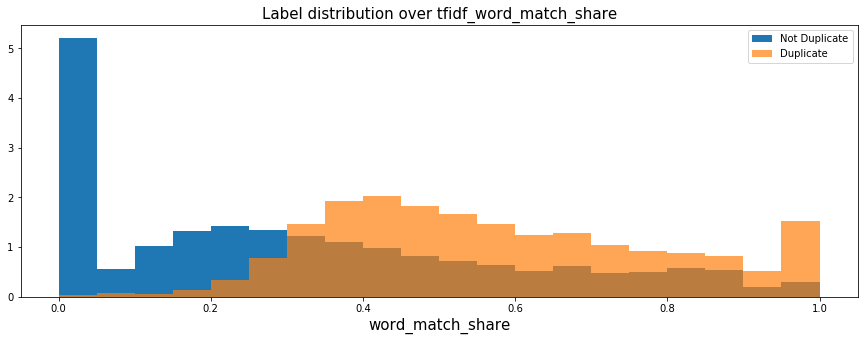

In [44]:
plt.figure(figsize=(15, 5))
plt.hist(tfidf_train_word_match[train['is_duplicate'] == 0].fillna(0), bins=20, normed=True, label='Not Duplicate')
plt.hist(tfidf_train_word_match[train['is_duplicate'] == 1].fillna(0), bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over tfidf_word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)
plt.savefig("tf-idf.jpg")

#### From the TF-IDF score, we can see that non-duplicates tends to have lower scores than duplicates. This is expected because non-duplicates may be about 

#### After we have done the data processing, we can start creating out training set for xgboost. For training, we choose to use xgboost for our model training as it is light weight and fast

#### Construct training set, select columns from trian

In [ ]:
train['word_match'] = train_word_match
train['tfidf_word_match'] = tfidf_train_word_match

In [52]:
X_all = train.drop(['id','qid1', 'qid2', 'question1', 'question2', 'is_duplicate' ,'question1_cleaned', 'question2_cleaned'], axis=1)
y_all = train.is_duplicate

In [53]:
x_train, x_valid, y_train, y_valid = train_test_split(X_all, y_all, test_size=0.2, random_state=4242)

## 3. Error Analysis

#### Use Word2vec to see the count of words

In [ ]:
# import wget
# word2vec_link = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

# word2vec_download = 'GoogleNews-vectors-negative300.bin.gz'

# wget.download(word2vec_link, out=word2vec_download)

In [ ]:
# from gensim.models.word2vec import Word2Vec
# from gensim.models.keyedvectors import KeyedVectors


# word2vec = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
# unique_words = {}

# for q in train['question1_cleaned']:
#     s = q.split()
#     for word in s:
#         if word in unique_words:
#             unique_words[word] += 1
#         else:
#             unique_words[word] = 1

# for q in train['question2_cleaned']:
#     s = q.split()
#     for word in s:
#         if word in unique_words:
#             unique_words[word] += 1
#         else:
#             unique_words[word] = 1
            
# unique_words_list = [ (v,k) for k,v in unique_words.items() ]
# unique_words_list = sorted(unique_words_list, reverse=True)

# rare_word_list = []

# for freq, word in unique_words_list:
#     if word not in word2vec.vocab:
#         rare_word_list.append((freq, word))

In [ ]:
# unique_words_list[:500]

In [ ]:
# rare_word_list[:500]

## 4. Modeling

In [59]:
X_all.columns

Index(['q1_set_len', 'q2_set_len', 'common_len', 'jaccard',
       'common_len_2_grams', 'jaccard_2_grams', 'common_len_3_grams',
       'jaccard_3_grams', 'cosine', 'q1_start_with_what', 'q2_start_with_what',
       'q1_start_with_how', 'q2_start_with_how', 'q1_start_with_why',
       'q2_start_with_why', 'q1_start_with_who', 'q2_start_with_who',
       'q1_start_with_where', 'q2_start_with_where', 'q1_start_with_when',
       'q2_start_with_when', 'q1_start_with_which', 'q2_start_with_which',
       'q1_start_with_can', 'q2_start_with_can', 'q1_start_with_should',
       'q2_start_with_should', 'q1_start_with_will', 'q2_start_with_will',
       'q1_start_with_is', 'q2_start_with_is', 'q1_start_with_do',
       'q2_start_with_do', 'word_match', 'tfidf_word_match'],
      dtype='object')

In [92]:
import xgboost as xgb

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
}

#d_train = xgb.DMatrix(x_train, label=y_train)
#d_valid = xgb.DMatrix(x_valid, label=y_valid)
d_train = xgb.DMatrix(X_all, label=y_all)
#watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 1200, watchlist, early_stopping_rounds=100, verbose_eval=10)



[20:12:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[0]	train-logloss:0.596654	valid-logloss:0.597816
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[20:12:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[20:12:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[20:12:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[20:12:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[20:12:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[20:12:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[20:12:

[20:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[20:13:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[70]	train-logloss:0.407292	valid-logloss:0.41136
[20:13:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[20:13:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[20:13:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[20:13:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[20:13:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[20:13:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[20:13:21] src/tree/updater_prune.cc:74: tree pr

[20:14:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 124 extra nodes, 0 pruned nodes, max_depth=6
[20:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[140]	train-logloss:0.394516	valid-logloss:0.398685
[20:14:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[20:14:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[20:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[20:14:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[20:14:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[20:14:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 122 extra nodes, 0 pruned nodes, max_depth=6
[20:14:09] src/tree/updater_prune.cc:74: tree pr

[20:14:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[20:14:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[210]	train-logloss:0.385861	valid-logloss:0.390056
[20:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[20:14:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[20:14:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[20:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[20:14:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[20:14:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[20:14:57] src/tree/updater_prune.cc:74: tree prun

[20:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[20:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[280]	train-logloss:0.37816	valid-logloss:0.382361
[20:15:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[20:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[20:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[20:15:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[20:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[20:15:44] src/tree/updater_prune.cc:74: tree

[20:16:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[20:16:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[350]	train-logloss:0.371184	valid-logloss:0.37509
[20:16:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[20:16:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[20:16:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[20:16:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[20:16:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[20:16:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[20:16:32] src/tree/updater_prune.cc:74: tree prun

[20:17:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[20:17:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=6
[420]	train-logloss:0.364444	valid-logloss:0.368288
[20:17:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[20:17:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[20:17:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[20:17:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[20:17:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[20:17:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[20:17:19] src/tree/updater_prune.cc:74: tree pru

[20:18:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[20:18:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[490]	train-logloss:0.358068	valid-logloss:0.361971
[20:18:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[20:18:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[20:18:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[20:18:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[20:18:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[20:18:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 0 pruned nodes, max_depth=6
[20:18:07] src/tree/updater_prune.cc:74: tree prun

[20:18:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[20:18:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[560]	train-logloss:0.352556	valid-logloss:0.356493
[20:18:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[20:18:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[20:18:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[20:18:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 92 extra nodes, 0 pruned nodes, max_depth=6
[20:18:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[20:18:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[20:18:54] src/tree/updater_prune.cc:74: tree prun

[20:19:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[20:19:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[630]	train-logloss:0.347443	valid-logloss:0.351219
[20:19:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[20:19:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 108 extra nodes, 0 pruned nodes, max_depth=6
[20:19:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=6
[20:19:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[20:19:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[20:19:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[20:19:41] src/tree/updater_prune.cc:74: tree prun

[20:20:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[20:20:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[700]	train-logloss:0.342643	valid-logloss:0.346362
[20:20:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[20:20:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[20:20:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=6
[20:20:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[20:20:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 90 extra nodes, 0 pruned nodes, max_depth=6
[20:20:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 126 extra nodes, 0 pruned nodes, max_depth=6
[20:20:28] src/tree/updater_prune.cc:74: tree prun

[20:21:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[20:21:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[770]	train-logloss:0.337232	valid-logloss:0.340766
[20:21:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 0 pruned nodes, max_depth=6
[20:21:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 118 extra nodes, 0 pruned nodes, max_depth=6
[20:21:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[20:21:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=6
[20:21:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[20:21:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[20:21:16] src/tree/updater_prune.cc:74: tree pr

[20:21:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=6
[20:21:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[840]	train-logloss:0.332521	valid-logloss:0.335872
[20:21:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[20:22:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[20:22:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[20:22:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=6
[20:22:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 0 pruned nodes, max_depth=6
[20:22:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=6
[20:22:03] src/tree/updater_prune.cc:74: tree prun

[20:22:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 0 pruned nodes, max_depth=6
[20:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[910]	train-logloss:0.328419	valid-logloss:0.331625
[20:22:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[20:22:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[20:22:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[20:22:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[20:22:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[20:22:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 0 pruned nodes, max_depth=6
[20:22:50] src/tree/updater_prune.cc:74: tree p

[20:23:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[20:23:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[980]	train-logloss:0.324225	valid-logloss:0.327462
[20:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max_depth=6
[20:23:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 72 extra nodes, 0 pruned nodes, max_depth=6
[20:23:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=6
[20:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[20:23:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=6
[20:23:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 74 extra nodes, 0 pruned nodes, max_depth=6
[20:23:38] src/tree/updater_prune.cc:74: tree pruni

[20:24:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[20:24:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[1050]	train-logloss:0.320328	valid-logloss:0.323563
[20:24:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[20:24:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[20:24:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[20:24:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 0 pruned nodes, max_depth=6
[20:24:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 0 pruned nodes, max_depth=6
[20:24:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=6
[20:24:24] src/tree/updater_prune.cc:74: tree pru

[20:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 0 pruned nodes, max_depth=6
[20:25:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 0 pruned nodes, max_depth=6
[1120]	train-logloss:0.316407	valid-logloss:0.319313
[20:25:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 0 pruned nodes, max_depth=6
[20:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 98 extra nodes, 0 pruned nodes, max_depth=6
[20:25:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[20:25:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 0 pruned nodes, max_depth=6
[20:25:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 0 pruned nodes, max_depth=6
[20:25:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[20:25:11] src/tree/updater_prune.cc:74: tree pr

[20:25:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[20:25:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 96 extra nodes, 0 pruned nodes, max_depth=6
[1190]	train-logloss:0.313188	valid-logloss:0.316051
[20:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=6
[20:25:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 78 extra nodes, 0 pruned nodes, max_depth=6
[20:25:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 100 extra nodes, 0 pruned nodes, max_depth=6
[20:25:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[20:25:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 0 pruned nodes, max_depth=6
[20:25:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[20:25:58] src/tree/updater_prune.cc:74: tree pru

### 4.1 Visualizing the comtributions by each feature

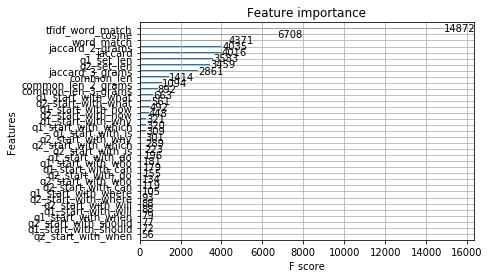

In [93]:
xgb.plot_importance(booster=bst)

#### Clearly, Jaccard similarity and word matching plays important role in this task

# 5. Featuring the test file

In [70]:
test['question1_cleaned'] = test['question1'].apply(cleaning)
test['question2_cleaned'] = test['question2'].apply(cleaning)
test['question1_cleaned'] = test['question1_cleaned'].apply(replace, replacements=replacements)
test['question2_cleaned'] = test['question2_cleaned'].apply(replace, replacements=replacements)
jaccard_params = test.apply(jaccard, axis=1)
test = pd.concat([test, jaccard_params], axis=1)
jaccard_2_gram = test.apply(jaccard_ngrams, axis=1, n=2, suffix='_2_grams')
test = pd.concat([test, jaccard_2_gram], axis=1)
jaccard_3_gram = test.apply(jaccard_ngrams, axis=1, n=3, suffix='_3_grams')
test = pd.concat([test, jaccard_3_gram], axis=1)
cosine_params = test.apply(cosine, axis=1)
test = pd.concat([test, cosine_params], axis=1)
test['q1_start_with_what'] = test['question1_cleaned'].apply(start_with, symbols=('what', "what's"))
test['q2_start_with_what'] = test['question2_cleaned'].apply(start_with, symbols=('what', "what's"))

test['q1_start_with_how'] = test['question1_cleaned'].apply(start_with, symbols=('how'))
test['q2_start_with_how'] = test['question2_cleaned'].apply(start_with, symbols=('how'))

test['q1_start_with_why'] = test['question1_cleaned'].apply(start_with, symbols=('why'))
test['q2_start_with_why'] = test['question2_cleaned'].apply(start_with, symbols=('why'))

test['q1_start_with_who'] = test['question1_cleaned'].apply(start_with, symbols=('who'))
test['q2_start_with_who'] = test['question2_cleaned'].apply(start_with, symbols=('who'))

test['q1_start_with_where'] = test['question1_cleaned'].apply(start_with, symbols=('where'))
test['q2_start_with_where'] = test['question2_cleaned'].apply(start_with, symbols=('where'))

test['q1_start_with_when'] = test['question1_cleaned'].apply(start_with, symbols=('when'))
test['q2_start_with_when'] = test['question2_cleaned'].apply(start_with, symbols=('when'))

test['q1_start_with_which'] = test['question1_cleaned'].apply(start_with, symbols=('which'))
test['q2_start_with_which'] = test['question2_cleaned'].apply(start_with, symbols=('which'))

test['q1_start_with_can'] = test['question1_cleaned'].apply(start_with, symbols=('can', 'could'))
test['q2_start_with_can'] = test['question2_cleaned'].apply(start_with, symbols=('can', 'could'))

test['q1_start_with_should'] = test['question1_cleaned'].apply(start_with, symbols=('should'))
test['q2_start_with_should'] = test['question2_cleaned'].apply(start_with, symbols=('should'))

test['q1_start_with_will'] = test['question1_cleaned'].apply(start_with, symbols=('will', 'would'))
test['q2_start_with_will'] = test['question2_cleaned'].apply(start_with, symbols=('will', 'would'))

test['q1_start_with_is'] = test['question1_cleaned'].apply(start_with, symbols=('is', 'am', 'are'))
test['q2_start_with_is'] = test['question2_cleaned'].apply(start_with, symbols=('is', 'am', 'are'))

test['q1_start_with_do'] = test['question1_cleaned'].apply(start_with, symbols=('do', 'does', 'did'))
test['q2_start_with_do'] = test['question2_cleaned'].apply(start_with, symbols=('do', 'does', 'did'))


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: generator 'ngrams' raised StopIteration
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: generator 'ngrams' raised StopIteration
  if __name__ == '__main__':


In [80]:
# modified from https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb
def word_match_share_test(row):
    q1words = []
    q2words = []
    
    for word in row['question1'].lower().split():
        if word not in stop_words:
            q1words.append(word)
    for word in row['question2'].lower().split():
        if word not in stop_words:
            q2words.append(word)
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words if w in q2words]
    shared_words_in_q2 = [w for w in q2words if w in q1words]
    return (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))

def tfidf_word_match_share_test(row):
    q1words = []
    q2words = []
    for word in row['question1'].lower().split():
        if word not in stop_words:
            q1words.append(word)
    for word in row['question2'].lower().split():
        if word not in stop_words:
            q2words.append(word)
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words if w in q2words] + [weights.get(w, 0) for w in q2words if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    return np.sum(shared_weights) / np.sum(total_weights)

In [81]:
test['word_match'] = test.apply(word_match_share_test, axis=1, raw=True)
test['tfidf_word_match'] = test.apply(tfidf_word_match_share_test, axis=1, raw=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars


In [86]:
test=test.drop(['q1_len','q2_len'],axis=1)

# 6. Run the model to predict the test file

In [87]:
test_all = test.drop(['question1', 'question2', 'question1_cleaned', 'question2_cleaned'], axis=1)
dtest = xgb.DMatrix(test_all)


In [94]:
predict = bst.predict(dtest)

In [95]:
sub = pd.DataFrame()
sub['test_id'] = test.index
sub['is_duplicate'] = predict
sub.head()

,test_id,is_duplicate
0,0,0.021488
1,1,0.151602
2,2,0.621277
3,3,0.000016
4,4,0.175545


In [96]:
sub.to_csv('result.csv', index = False)

# 7. Conclusion and Futher work

Using this notebook we were able to get a score around 0.35, this project is mainly about checking if two questions are about the same. For further development, we would try first extend it to all kinds of sentences and then to sentences between languages like we did in homework 4. In that case, the model would be able to compare if two sentences are about the same subject between English, French and German.

#  